In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.stattools import acf, pacf

import xgboost as xgb
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

import datetime
warnings.filterwarnings('ignore')
path = "D:/program/program1/Cargo_forecast/dot_data_all/"
print(os.listdir(path))

['20181207dot1.xlsx', '20181207_莉娜_点部#1.xlsx', '20181207_莉娜_点部#2.xlsx', '20181207_莉娜_点部#3.xlsx', '20190103_1.csv', '20190103_2.csv', '20190103_点部取货量_1.xlsx', '20190103_点部取货量_2.xlsx', '20190103_点部派货量_1.xlsx', '20190103_点部派货量_2.xlsx', '20190218.csv', 'accurate.xlsx', 'comments.txt', 'document.csv', 'dot.csv', 'dot_result.csv', 'dot_result_new.csv', 'feature_importance.png', 'rmse1.csv', 'test.csv', 'test_predict.png']


In [2]:
dot_data_1 = pd.read_excel(path + '20190103_点部取货量_1.xlsx', parse_dates=[1])
dot_data_2 = pd.read_excel(path + '20190103_点部取货量_2.xlsx', parse_dates = [1])

In [3]:
dot_data_3 = pd.read_csv(path + 'dot.csv', header = None, names = ['dot', 'dot_type', 'area', 'city_code', 'department', 'province', 'city', 'district', 'town', 'village'])


In [4]:
dot_data_tmp = pd.concat([dot_data_1,dot_data_2],ignore_index = True)
dot_data_tmp = dot_data_tmp.drop(['num', 'jifei_weight', 'shiji_weight', 'longitude', 'latitude'], axis = 1)

In [5]:
# dot_data_3.loc[dot_data_3['city'].isnull(), ['city']] = dot_data_3.loc[dot_data_3['city'].isnull(), ['province']].values
# dot_data_3.loc[dot_data_3['district'].isnull(), ['district']] = dot_data_3.loc[dot_data_3['district'].isnull(), ['city']].values
dot_data_3.drop(['department', 'city', 'district', 'town', 'village'], axis = 1, inplace = True)
dot_data_3.head()

,dot,dot_type,area,city_code,province
0,清江新下塘点部,大点部,华东,577,浙江省
1,香洲洪湾点部,大点部,华南,756,广东省
2,贵阳三甫点部,大点部,华北,851,贵州省
3,镇江大港点部,大点部,华东,511,江苏省
4,三水竹山点部,大点部,华南,757,广东省


In [6]:
dot_data = pd.merge(dot_data_tmp, dot_data_3, how = 'left', on = 'dot')
dot_data.dropna(axis = 0, inplace = True)
dot_data.reset_index(drop = True, inplace = True)

In [7]:
dot_data.head()

,dot,order_date,order_num,dot_type,area,city_code,province
0,三水木棉点部,2018-05-28,1,大点部,华南,757.0,广东省
1,三水木棉点部,2018-06-08,29,大点部,华南,757.0,广东省
2,三水木棉点部,2018-06-13,43,大点部,华南,757.0,广东省
3,三水木棉点部,2018-06-17,4,大点部,华南,757.0,广东省
4,三水木棉点部,2018-07-16,33,大点部,华南,757.0,广东省


In [8]:
data_res_tmp = dot_data.copy()

In [9]:
data_res = pd.concat([data_res_tmp, pd.get_dummies(data_res_tmp['dot_type']), pd.get_dummies(data_res_tmp['area']), pd.get_dummies(data_res_tmp['province'])], axis = 1)
data_res.drop(['dot_type', 'area', 'province'], axis = 1, inplace = True)
data_res.head()

,dot,order_date,order_num,city_code,一级中转场,二级中转场,大点部,小点部,航空组,虚拟点部,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
0,三水木棉点部,2018-05-28,1,757.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,三水木棉点部,2018-06-08,29,757.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,三水木棉点部,2018-06-13,43,757.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,三水木棉点部,2018-06-17,4,757.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,三水木棉点部,2018-07-16,33,757.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
data_ts = data_res.copy()
data_ts.index = pd.to_datetime(data_ts['order_date'])

In [11]:
data_ts.sort_index(ascending = True, inplace = True)
data_ts = data_ts['2017-12':]
data_ts.head()

,dot,order_date,order_num,city_code,一级中转场,二级中转场,大点部,小点部,航空组,虚拟点部,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
order_date,,,,,,,,,,,,,,,,,,,,,
2017-12-01,溧水后白点部,2017-12-01,5,511.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-01,盛泽新鹤点部,2017-12-01,11,512.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-01,甪直元丰点部,2017-12-01,55,512.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-01,顺德城区点部,2017-12-01,33,757.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-01,金山吕巷点部,2017-12-01,15,21.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
data_count = pd.DataFrame(data_ts['order_date'].groupby(data_ts['dot']).count())
data_count.reset_index(inplace = True)
useful_dot_name = data_count.loc[data_count['order_date'] >= 390, ['dot']]
len(useful_dot_name)

333

In [13]:
dot_preprocessing = pd.DataFrame()
for i, dot in enumerate(useful_dot_name['dot']):
    one_dot = data_res.loc[data_res['dot'] == dot]
    one_dot = one_dot.loc[one_dot["order_date"] >= pd.to_datetime('2017-12-01')]
    num_median = np.median(one_dot['order_num'])
    ts = pd.date_range('2017-12-01', '2018-12-31')
    df_ts = pd.DataFrame(ts, columns = ['order_date'])
    df_ts['dot'] = dot
    df_ts['dot_id'] = i + 1
    merge_res = pd.merge(df_ts, one_dot, how= 'left')
#     merge_res = merge_res.loc[merge_res["order_date"] >= pd.to_datetime('2017-12-01')]
    merge_res['order_num'].fillna(num_median, inplace = True)
    if len(merge_res) >= 390:
        dot_preprocessing = pd.concat([dot_preprocessing, merge_res], axis = 0,ignore_index = True)

In [14]:
dot_preprocessing.head()

,order_date,dot,dot_id,order_num,city_code,一级中转场,二级中转场,大点部,小点部,航空组,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
0,2017-12-01,东丽机场点部,1,40.0,22.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-12-02,东丽机场点部,1,36.0,22.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-12-03,东丽机场点部,1,14.0,22.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-12-04,东丽机场点部,1,64.0,22.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-12-05,东丽机场点部,1,48.0,22.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
dot_prep = dot_preprocessing.copy()
dot_prep['order_num'] = np.log1p(dot_prep['order_num'])
dot_prep.sort_values(by = ['order_date'], inplace = True)
dot_prep.head()

,order_date,dot,dot_id,order_num,city_code,一级中转场,二级中转场,大点部,小点部,航空组,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
0,2017-12-01,东丽机场点部,1,3.713572,22.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102564,2017-12-01,石岩又一村点部,260,4.605170,755.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29304,2017-12-01,坂田上雪点部,75,5.749393,755.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12672,2017-12-01,南通兴东点部,33,3.526361,513.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119196,2017-12-01,闵行曹行点部,302,4.934474,21.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
def time_feature(data):
    # 时间
    dot_prep_1 = data.copy()
    
    dot_prep_1['year'] = dot_prep_1.order_date.dt.year
    dot_prep_1['month'] = dot_prep_1.order_date.dt.month
    dot_prep_1['day'] = dot_prep_1.order_date.dt.day
    dot_prep_1['dayofweek'] = dot_prep_1.order_date.dt.dayofweek
    dot_prep_1['dayofyear'] = dot_prep_1.order_date.dt.dayofyear
    dot_prep_1['weekofyear'] = dot_prep_1.order_date.dt.weekofyear
    
    weekofsun = pd.date_range('2017-12-01', periods = round(len(dot_prep['order_date'].unique())/7), freq = 'W-SUN')
    dot_prep_1['weekofsun'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(weekofsun), ['weekofsun']] = 1
    
    dot_prep_1['holidays'] = 0
    dot_prep_1.loc[dot_prep_1['order_date'].isin(
    pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2017-01-23','2017-01-24', '2017-01-25',
                    '2017-01-26','2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
                    '2017-02-03','2017-02-04','2018-02-12', '2018-02-13',  '2018-02-14','2018-02-15', '2018-02-16', '2018-02-17', 
                    '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21','2018-02-22','2018-02-23', '2018-02-24', '2019-02-01', 
                    '2019-02-02', '2019-02-03','2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-09', 
                    '2019-02-10', '2019-02-11', '2019-02-12', '2019-02-13','2017-04-02', '2017-04-03', '2017-04-04', '2018-04-05', 
                    '2018-04-06', '2018-04-07', '2019-04-05', '2019-04-06', '2019-04-07','2017-05-01', '2017-05-02', '2017-05-03', 
                    '2018-05-01', '2018-05-02', '2018-05-03', '2019-05-01', '2019-05-02', '2019-05-03','2017-05-30', '2018-06-18', 
                    '2019-06-07', '2017-10-04', '2018-09-22', '2018-09-23', '2018-09-24', '2019-09-13', '2019-09-14', '2019-09-15',
                    '2017-10-01', '2017-10-02', '2017-10-03',  '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07','2018-10-01',
                    '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07', '2019-10-01', '2019-10-02', 
                    '2019-10-03', '2019-10-04', '2019-10-05', '2019-10-06', '2019-10-07'])), ['holidays']] = 1
    return dot_prep_1

def create_feature(data):
    dot_prep_1 = time_feature(data)
    dot_prep_ts = data.copy()
    dot_prep_ts.index = pd.to_datetime(dot_prep_ts['order_date'])
    
    dot_prep_2 = pd.DataFrame()
    dot_prep_3 = pd.DataFrame()
    for dot in useful_dot_name['dot']:
        dot_ts = dot_prep_ts.loc[dot_prep_ts['dot'] == dot, ['order_num']]
        dot_ts.sort_index(ascending = True, inplace = True)
        # lagging
        lagging = pd.concat([dot_ts.shift(1), dot_ts.shift(2), dot_ts.shift(3), dot_ts.shift(4), dot_ts.shift(5), dot_ts.shift(6), dot_ts.shift(7)], axis = 1)
        lagging.columns = ['lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6', 'lagging7']
        lagging['dot'] = dot
        lagging['order_date'] = dot_ts.index
        lagging.dropna(axis = 0, inplace = True)
        dot_prep_2 = pd.concat([dot_prep_2, lagging], axis = 0)
        
        # rolling
        rolling = pd.concat([dot_ts.rolling(window = 3).mean(), dot_ts.rolling(window = 5).mean(), dot_ts.rolling(window = 7).mean()], axis = 1)
        rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling.dropna(axis = 0, inplace = True)
        dot_prep_3 = pd.concat([dot_prep_3, rolling], axis = 0)
    dot_prep_2.reset_index(drop = True, inplace = True)
    dot_prep_3.reset_index(drop = True, inplace = True)
    
    # merge
    dot_prep_result_tmp = pd.merge(dot_prep_1, dot_prep_2, how = 'right', on = ['dot', 'order_date'])
    dot_prep_result = pd.merge(dot_prep_result_tmp, dot_prep_3, how = 'left', on = ['dot', 'order_date'])
    dot_prep_result.sort_values(by = 'order_date', ascending = True, inplace = True)
#     dot_prep_result.drop(['dot', 'order_date'], axis = 1, inplace = True)
    
    return dot_prep_result

In [18]:
dot_prep_feature = create_feature(dot_prep)

In [ ]:
dot_prep_feature.head()

In [19]:
dot_train = dot_prep_feature[: -(30 * 338)]
dot_test = dot_prep_feature[-(30 * 338) :]

In [20]:
dot_xtrain = dot_train.drop(['order_num'], axis = 1)
dot_ytrain = dot_train['order_num']
dot_xtest = dot_test.drop(['order_num'], axis = 1)
dot_ytest = dot_test['order_num']

In [21]:
def RMSE(y_test, y_pred):
    return np.sqrt(np.sum((y_test - y_pred) ** 2)/len(y_test))

def MAE(y_test, y_pred):
    return np.sum(np.abs(y_test - y_pred))/len(y_test)

In [22]:
def xgboost_model(x_train, y_train):
    params = {
        "learning_rate": 0.01,
        "n_estimators": 3300,
        "max_depth": 5,
        "min_child_weight": 3,
        "gamma": 0.5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "silent": 1,
        "reg_alpha" : 0.05,
        "reg_lambda" : 0.05,
        "seed": 21
    }
    print("train_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    gbm = xgb.XGBRegressor(**params)
    gbm.fit(x_train.drop(['dot', 'order_date'], axis = 1), y_train)
    print("train_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    for column, importance in zip(x_train.drop(['dot', 'order_date'], axis = 1).columns, gbm.feature_importances_):
        print(column, '\t', importance)
    # plot_importance(gbm)
    # plt.savefig(path + "feature_importance.png")
    
    return gbm

In [23]:
gbm = xgboost_model(dot_xtrain, dot_ytrain)

train_start :  2019-02-19 14:12:57
train_end :  2019-02-19 14:31:46
dot_id 	 0.05089941
city_code 	 0.04570414
一级中转场 	 0.0020236687
二级中转场 	 0.00043786984
大点部 	 0.0045680474
小点部 	 0.0010295858
航空组 	 0.0
虚拟点部 	 0.0
京津冀 	 0.0013254437
华东 	 0.0028402368
华北 	 0.0006035503
华南 	 0.001704142
上海 	 0.0031242603
云南省 	 0.0
内蒙古 	 0.0
北京 	 0.00020118343
吉林省 	 0.0
四川省 	 0.0
天津 	 0.0013017751
安徽省 	 0.0021538462
山东省 	 0.001183432
山西省 	 0.0
广东省 	 0.0050295857
广西 	 0.0
新疆 	 0.0
江苏省 	 0.004698225
江西省 	 0.00015384615
河北省 	 0.0042721895
河南省 	 0.0
浙江省 	 0.014615385
海南省 	 0.0
湖北省 	 0.0010532545
湖南省 	 0.0
甘肃省 	 0.0
福建省 	 0.0015857988
贵州省 	 0.0
辽宁省 	 0.0011952663
重庆 	 0.0
陕西省 	 0.0
黑龙江省 	 0.0
year 	 0.00066272187
month 	 0.012946745
day 	 0.054142013
dayofweek 	 0.0592071
dayofyear 	 0.081242606
weekofyear 	 0.006639053
weekofsun 	 0.0064615384
holidays 	 0.03347929
lagging1 	 0.09416568
lagging2 	 0.05693491
lagging3 	 0.04507692
lagging4 	 0.048011836
lagging5 	 0.05139645
lagging6 	 0.057171598
lagging7 	 0.

## 预测方式1

In [34]:
def xgb_predict(gbm, x_test, y_test, path):
    # 验证
    print("predict_start : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    print("predict_end : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'y_test' : np.expm1(y_test), 'y_pre' : np.expm1(y_pre)})
    result['RMSE'] = RMSE(np.expm1(y_test), np.expm1(y_pre))
    result['MAE'] = MAE(np.expm1(y_test), np.expm1(y_pre))
    print("MAE : ", MAE(np.expm1(y_test), np.expm1(y_pre)), " RMSE : ", RMSE(np.expm1(y_test), np.expm1(y_pre)))
    
    result.to_csv(path + "dot_result.csv", encoding = 'GBK', index = False)
    return result

In [35]:
result = xgb_predict(gbm, dot_xtest, dot_ytest, path)

predict_start :  2019-02-19 14:36:13
predict_end :  2019-02-19 14:36:15
MAE :  19.414292028904903  RMSE :  71.81666685226983


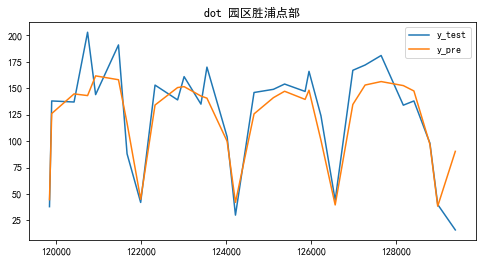

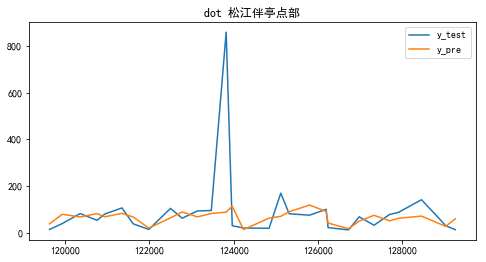

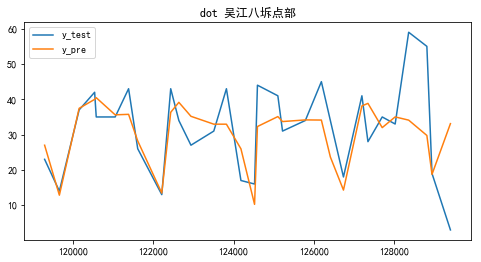

In [36]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_test','y_pre']
L = np.random.randint( low = 0, high = 337, size = 3 )
for i in L:
    s1 = pd.DataFrame(result[result['dot'] == result['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(result['dot'].unique()[i]), figsize = (8,4))

## 预测方式2

In [37]:
def pre_feature(data, dot_name):
    x_test_tmp = pd.DataFrame()
    rolling_tmp = pd.DataFrame()
    for dot in dot_name['dot']:
        # lagging
        dot_test = data.loc[data['dot'] == dot]
        dot_test_ts = dot_test.copy()
        dot_test['lagging7'] = dot_test['lagging6']
        dot_test['lagging6'] = dot_test['lagging5']
        dot_test['lagging5'] = dot_test['lagging4']
        dot_test['lagging4'] = dot_test['lagging3']
        dot_test['lagging3'] = dot_test['lagging2']
        dot_test['lagging2'] = dot_test['lagging1']
        dot_test['lagging1'] = dot_test['order_num']

        x_test_tmp = pd.concat([x_test_tmp, dot_test])

        # rolling
        dot_test_ts.index = pd.to_datetime(dot_test_ts['order_date'])
        num_ts = dot_test_ts.loc[dot_test_ts['dot'] == dot, ['order_num']]
        rolling = pd.concat([num_ts.rolling(window = 3).mean(), num_ts.rolling(window = 5).mean(), num_ts.rolling(window = 7).mean()], axis = 1)
    #     rolling.index = rolling.index + pd.DateOffset(days = 1)
        rolling.columns = ['rolling3', 'rolling5', 'rolling7']
        rolling['dot'] = dot
        rolling['order_date'] = rolling.index
        rolling_tmp = pd.concat([rolling_tmp, rolling])

    x_test = pd.merge(x_test_tmp.drop(['rolling3', 'rolling5', 'rolling7'], axis = 1), rolling_tmp, how = 'left', on = ['dot', 'order_date'])
    x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = 1)
    x_test.dropna(axis = 0, inplace = True)
    
    return x_test

In [38]:
dot_train.columns

Index(['order_date', 'dot', 'dot_id', 'order_num', 'city_code', '一级中转场',
       '二级中转场', '大点部', '小点部', '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海',
       '云南省', '内蒙古', '北京', '吉林省', '四川省', '天津', '安徽省', '山东省', '山西省', '广东省',
       '广西', '新疆', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省',
       '甘肃省', '福建省', '贵州省', '辽宁省', '重庆', '陕西省', '黑龙江省', 'year', 'month', 'day',
       'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays',
       'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6',
       'lagging7', 'rolling3', 'rolling5', 'rolling7'],
      dtype='object')

In [39]:
print("START : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
result_to_csv = pd.DataFrame()
org_test = dot_train.copy()
feature = ['order_date', 'dot', 'dot_id', 'city_code', '一级中转场',
       '二级中转场', '大点部', '小点部', '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海',
       '云南省', '内蒙古', '北京', '吉林省', '四川省', '天津', '安徽省', '山东省', '山西省', '广东省',
       '广西', '新疆', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省',
       '甘肃省', '福建省', '贵州省', '辽宁省', '重庆', '陕西省', '黑龙江省',
       'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6',
       'lagging7', 'rolling3', 'rolling5', 'rolling7']
feature_num = ['order_date', 'dot', 'dot_id', 'city_code', '一级中转场',
       '二级中转场', '大点部', '小点部', '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海',
       '云南省', '内蒙古', '北京', '吉林省', '四川省', '天津', '安徽省', '山东省', '山西省', '广东省',
       '广西', '新疆', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省',
       '甘肃省', '福建省', '贵州省', '辽宁省', '重庆', '陕西省', '黑龙江省', 'year', 'month', 'day',
       'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays',
       'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6',
       'lagging7', 'rolling3', 'rolling5', 'rolling7']
feature_date = ['order_date', 'dot', 'dot_id', 'order_num', 'city_code', '一级中转场',
       '二级中转场', '大点部', '小点部', '航空组', '虚拟点部', '京津冀', '华东', '华北', '华南', '上海',
       '云南省', '内蒙古', '北京', '吉林省', '四川省', '天津', '安徽省', '山东省', '山西省', '广东省',
       '广西', '新疆', '江苏省', '江西省', '河北省', '河南省', '浙江省', '海南省', '湖北省', '湖南省',
       '甘肃省', '福建省', '贵州省', '辽宁省', '重庆', '陕西省', '黑龙江省', 'year', 'month', 'day',
       'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays',
       'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5', 'lagging6',
       'lagging7', 'rolling3', 'rolling5', 'rolling7']
for i in range(30):
    print(i)
    x_test = pre_feature(org_test, useful_dot_name)
    last_train_date = pd.to_datetime('2018-12-01') + pd.DateOffset(days = i + 1)
    x_test = x_test.loc[x_test['order_date'] == last_train_date, feature]#.drop(['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'weekofsun', 'holidays'])
#     x_test['order_date'] = x_test['order_date'] + pd.DateOffset(days = i)
    
    x_test = time_feature(x_test)
    x_test = x_test[feature_num]

    y_pre = gbm.predict(x_test.drop(['dot', 'order_date'], axis = 1))
    result = pd.DataFrame({'dot' : x_test['dot'], 'order_date' : x_test['order_date'], 'order_num' : y_pre})
    result_to_csv = pd.concat([result_to_csv, result])
    x_test = pd.merge(x_test, result, on = ['dot', 'order_date'], how = 'left')
    x_test = x_test[feature_date]
    
    org_test = pd.concat([org_test, x_test])
print("END : ", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

START :  2019-02-19 14:42:09
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
END :  2019-02-19 15:18:04


In [40]:
result_to_csv['order_num'] = np.expm1(result_to_csv['order_num'])
result_to_csv.head()

,dot,order_date,order_num
358,东丽机场点部,2018-12-02,54.653530
1075,东升宝丰点部,2018-12-02,15.465733
1434,中山沙溪点部,2018-12-02,28.150270
2509,义乌后宅点部,2018-12-02,348.222260
2868,义乌幸福点部,2018-12-02,423.428711


In [41]:
org_data = dot_prep.copy()
org_data['order_num'] = np.expm1(org_data['order_num'])
org_data.tail()

,order_date,dot,dot_id,order_num,city_code,一级中转场,二级中转场,大点部,小点部,航空组,...,海南省,湖北省,湖南省,甘肃省,福建省,贵州省,辽宁省,重庆,陕西省,黑龙江省
117215,2018-12-31,金山朱泾点部,296,122.0,21.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93455,2018-12-31,甪直南港点部,236,29.0,512.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38015,2018-12-31,天河元岗点部,96,43.0,20.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13859,2018-12-31,南通启东点部,35,22.0,513.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131867,2018-12-31,龙岗龙东点部,333,29.0,755.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
r1 = pd.merge(result_to_csv, org_data, on = ['dot', 'order_date'], how = 'left')
r1 = r1[['dot', 'order_date', 'order_num_x', 'dot_id', 'order_num_y']]
r1.columns = ['dot', 'order_date', 'y_pre', 'dot_id', 'y_test']
r1 = r1[['dot', 'order_date', 'dot_id', 'y_test', 'y_pre']]
r1.head()

,dot,order_date,dot_id,y_test,y_pre
0,东丽机场点部,2018-12-02,1,86.0,54.653530
1,东升宝丰点部,2018-12-02,3,21.0,15.465733
2,中山沙溪点部,2018-12-02,4,38.0,28.150270
3,义乌后宅点部,2018-12-02,7,246.0,348.222260
4,义乌幸福点部,2018-12-02,8,216.0,423.428711


In [44]:
print("MAE : ", MAE(r1.y_test, r1.y_pre))
print("RMSE : ", RMSE(r1.y_test, r1.y_pre))

MAE :  25.38725191217954
RMSE :  87.43753399564997


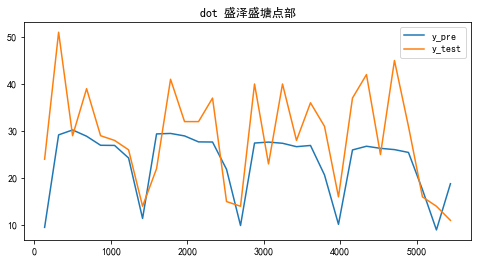

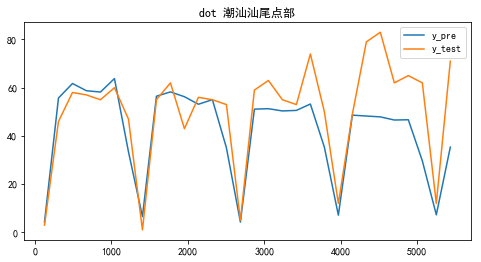

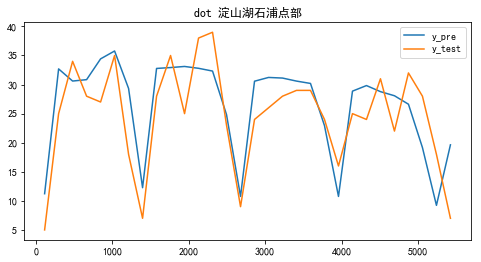

In [51]:
plt.rcParams['font.sans-serif']=['SimHei']
col_1 = ['y_pre','y_test']
L = np.random.randint( low = 0, high = 183, size = 3 )
for i in L:
    s1 = pd.DataFrame(r1[r1['dot'] == r1['dot'].unique()[i]], columns = col_1)
    s1.plot(title = 'dot {}'.format(r1['dot'].unique()[i]), figsize = (8,4))